# Figure 2a)

here we will provide the code to generate figure 2 in https://arxiv.org/abs/2308.07810

In [ ]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return -1

In [2]:
# Parameters
Gamma = 1
Omega = 1
Rabi = np.sqrt((Gamma)**2 + Omega**2)
dt = 0.0012
tf = 6
t_cutoff = 6
t = np.arange(0, tf, dt)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 0)
rhoss = steadystate(H, c_ops)

unconditional_result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy, sz, g])
ez_un = unconditional_result.expect[1]
ey_un = unconditional_result.expect[0]
g_un = unconditional_result.expect[2]

N_cutoff = 1

In [3]:
# number of chargers to truncate at 
Nm = 20
dN = 0.06
N = np.arange(-10, N_cutoff, dN)

# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
Pn_vec = diff.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 4999/4999 [00:11<00:00, 431.17it/s]


In [4]:
# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2)*dt - Et**2

In [11]:
ntraj = 5000
result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[sy, g], store_measurement=True, ntraj=ntraj)

10.0%. Run time:  22.95s. Est. time left: 00:00:03:26
20.0%. Run time:  46.91s. Est. time left: 00:00:03:07
30.0%. Run time:  69.98s. Est. time left: 00:00:02:43
40.0%. Run time:  98.94s. Est. time left: 00:00:02:28
50.0%. Run time: 132.81s. Est. time left: 00:00:02:12
60.0%. Run time: 167.21s. Est. time left: 00:00:01:51
70.0%. Run time: 200.26s. Est. time left: 00:00:01:25
80.0%. Run time: 223.27s. Est. time left: 00:00:00:55
90.0%. Run time: 245.75s. Est. time left: 00:00:00:27
Total run time: 268.32s


In [14]:
# get measurement results
dIy = np.real(np.array(result.measurement).reshape(ntraj, len(t)))

# Integrated current
Iy = dt*np.cumsum(dIy, axis=1)

# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in Iy])
inds_f = inds[inds != None]

# Get first hitting times
hitting_times = t[list(inds_f)]

# Make a copy of Iy to compube absorbed trajectories
dIy_copy = dIy.copy()
Iy_final = []

for i in range(ntraj):
    if inds[i]==-1:
        Iy_final.append(dt*np.sum(dIy[i, :]))
    else:
        # Iy_copy[i, inds[i]:] = Iy_copy[i, inds[i]]
        dIy_copy[i, inds[i]:] = 0

# Work with abosrbing boundary conditions
Iy_ab = dt*np.cumsum(dIy_copy, axis=1)

In [15]:
# Integrate first hitting time distribution to t_cutoff
PT = np.sum(dGt)*dt

# compute norm of the work distribution
Pn_Norm = np.sum(Pn_vec[:,-1])

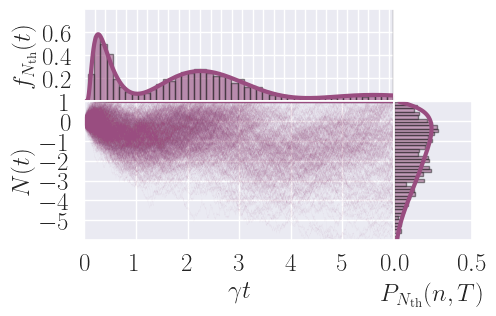

In [16]:
fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(5, 5)

color = [0.6, 0.3, 0.5]
fs = 18

ax1 = fig.add_subplot(gs[:2, :4])
ax1.plot(t, dGt, color=color, linewidth=3)
ax1.fill_between(t, dGt, color=color, alpha=0.2)
ax1.hist(hitting_times[t<tf-1], bins=50, color=color, alpha=0.5, density=True, edgecolor='k')

plt.xticks(np.arange(0, tf, 0.2), [])
plt.xlim(0, t_cutoff-0.1)
plt.yticks(np.arange(0.2, 0.7, 0.2), fontsize=fs)
plt.ylim(0, 0.8)
plt.ylabel(r'$f_{N_{\rm th}}(t)$', fontsize=fs)

ax2 = fig.add_subplot(gs[2:5, :4])
ax2.plot(t, Iy_ab[:900].T, color=color, linewidth=0.1, alpha=0.1)

plt.ylim(-6, N_cutoff)
plt.yticks(np.arange(-5, N_cutoff+1, 1), fontsize=fs)
plt.xticks(np.arange(0, t_cutoff, 1), fontsize=fs)
plt.xlim(0, t_cutoff+0.01)
plt.ylabel(r'$N(t)$', fontsize=fs)
plt.xlabel(r'$\gamma t$', fontsize=fs)

ax3 = fig.add_subplot(gs[2:, 4])
ax3.plot(Pn_vec[:, -1]/(dN*Pn_Norm), N[N<N_cutoff], color=color, linewidth=3)
ax3.hist(Iy_final, bins=50, orientation='horizontal', color=color, alpha=0.5, density=True, edgecolor='k')
plt.yticks(np.arange(-5, N_cutoff+1, 1),[])
plt.ylim(-6, N_cutoff)
plt.xticks(np.arange(0.0, 1, 0.5), fontsize=fs)

plt.xlabel(r'$P_{N_{\rm th}}(n, T)$', fontsize=fs)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

# fig.savefig('Figures/Diffusion_example.png', bbox_inches='tight', dpi=200)


# Figure 2b)

Increase $N_{\rm th}$ and see how error in FPT increases 

In [3]:
# Create stochastics simulations
# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
H = Omega*sx

# Parameters
Gamma = 1
Omega = 1

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 0)
rhoss = steadystate(H, c_ops)

# Loop over different values of N_cutoff and t_cutoff
dt = 0.0012

t_cutoff = 100
t = np.arange(0, t_cutoff, dt)

ntraj = 1000
result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[sy, g], store_measurement=True, ntraj=ntraj)

10.0%. Run time:  97.29s. Est. time left: 00:00:14:35
20.0%. Run time: 194.64s. Est. time left: 00:00:12:58
30.0%. Run time: 292.27s. Est. time left: 00:00:11:21
40.0%. Run time: 389.29s. Est. time left: 00:00:09:43
50.0%. Run time: 486.83s. Est. time left: 00:00:08:06
60.0%. Run time: 584.45s. Est. time left: 00:00:06:29
70.0%. Run time: 681.27s. Est. time left: 00:00:04:51
80.0%. Run time: 778.28s. Est. time left: 00:00:03:14
90.0%. Run time: 875.18s. Est. time left: 00:00:01:37
Total run time: 972.03s


In [5]:
Nmax = 6
# repeat using our method
N_cutoffs_2 = np.arange(1, Nmax, 1)

E_estimate = np.zeros((len(N_cutoffs_2)))
P0s = np.zeros((len(N_cutoffs_2)))

# Loop over different values of N_cutoff and t_cutoff
dts = 0.006

ts = np.arange(0, t_cutoff, dts)

for j, N_cutoff in enumerate(N_cutoffs_2):

    print('t_cutoff = {}, N_cutoff = {}'.format(t_cutoff, N_cutoff))

    # number of chargers to truncate at 
    Nm = N_cutoff
    dN = 0.1
    N = np.arange(-20, Nm, dN)

    # ------ Solve n-resolved method with absorbing boundary conditions ------ #
    diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, ts, N, N_cutoff, kind='single')
    Pn_vec = diff.solve(rho0)

    # Compute survival probability from analytic solution
    P0 = np.sum(Pn_vec, axis=0)
    dGt = -np.gradient(P0, dts)

    # Compute mean and variance of distribution
    E_estimate[j] = np.sum(dGt * ts)*dts
    P0s[j] = np.sum(dGt)*dts

t_cutoff = 100, N_cutoff = 1
Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 16666/16666 [00:28<00:00, 591.05it/s]


t_cutoff = 100, N_cutoff = 2
Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 16666/16666 [00:26<00:00, 617.69it/s]


t_cutoff = 100, N_cutoff = 3
Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 16666/16666 [00:30<00:00, 553.56it/s]


t_cutoff = 100, N_cutoff = 4
Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 16666/16666 [00:37<00:00, 450.01it/s]


t_cutoff = 100, N_cutoff = 5
Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 16666/16666 [00:35<00:00, 474.28it/s]


In [8]:
N_cutoffs = np.arange(1, Nmax, 1)
E_hitting_Ts = np.zeros((len(N_cutoffs)))
std_hitting_Ts = np.zeros((len(N_cutoffs)))
N_vals = np.zeros((len(N_cutoffs)))

for j, N_cutoff in enumerate(N_cutoffs):

    print('t_cutoff = {}, N_cutoff = {}'.format(t_cutoff, N_cutoff))


    ## get measurement results
    dIy = np.real(np.array(result.measurement).reshape(ntraj, len(t)))

    # Work without absorbing boundary conditions
    Iy = dt*np.cumsum(dIy, axis=1)

    # Get first hitting times
    inds = np.array([get_first_hit(mi, N_cutoff) for mi in Iy])
    inds_f = inds[inds != None]
    inds_f = inds_f[inds_f != -1]

    # Get first hitting times
    hitting_times = t[list(inds_f)]

    # get mean and variance
    E_hitting_Ts[j] = np.mean(hitting_times)
    std_hitting_Ts[j] = np.std(hitting_times)
    N_vals[j] = len(hitting_times)


t_cutoff = 100, N_cutoff = 1
t_cutoff = 100, N_cutoff = 2
t_cutoff = 100, N_cutoff = 3
t_cutoff = 100, N_cutoff = 4
t_cutoff = 100, N_cutoff = 5


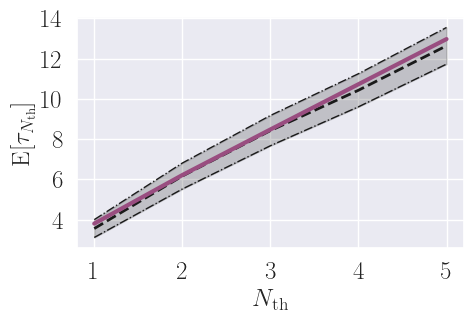

In [41]:
rng = 3
upper = E_hitting_Ts + rng*std_hitting_Ts/np.sqrt(N_vals)
lower = E_hitting_Ts - rng*std_hitting_Ts/np.sqrt(N_vals)

color = [0.6, 0.3, 0.5]
fs = 18

fig = plt.figure(figsize=(5, 3))
plt.plot(N_cutoffs, E_hitting_Ts, color='k', linewidth=2, linestyle='--')
plt.plot(N_cutoffs, upper, color='k', linewidth=1, linestyle='-.')
plt.plot(N_cutoffs, lower, color='k', linewidth=1, linestyle='-.')
plt.fill_between(N_cutoffs, upper, lower, color='k', alpha=0.2)

# plt.errorbar(N_cutoffs, E_hitting_Ts, yerr=rng*std_hitting_Ts/np.sqrt(N_vals), color='k', markersize=100, capsize=5, capthick=2, linestyle='')


plt.plot(N_cutoffs_2, E_estimate, color=color, linewidth=3)

# plt.ylim(0, 10)

plt.xticks(N_cutoffs_2, fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlabel(r'$N_{\rm th}$', fontsize=fs)
plt.ylabel(r'${\rm E}[\tau_{N_{\rm th}}]$', fontsize=fs)

plt.show()

fig.savefig('Figures/Diffusion_example_2.png', bbox_inches='tight', dpi=200)